# CineMatch: Building a Netflix-Style Movie Recommender System

- **Author:** Jay Dayal Guwalani
- **UID:** 121479709 
- **Course:** MSML602 - Principles of Data Science  
- **Institution:** University of Maryland  
- **Date:** December 2026
- **Github Page - Web Link:** https://jayds22.github.io/

---

## 1. Introduction and Motivation

### 1.1 The Problem of Choice Overload

In today's digital age, we face an unprecedented abundance of content. Netflix alone hosts over 15,000 titles, Amazon Prime Video offers more than 24,000 movies and shows, and new content is added daily. This phenomenon, known as **choice overload** or the **paradox of choice** (a term coined by psychologist Barry Schwartz in his 2004 book), can actually decrease user satisfaction and engagement. When faced with too many options, users often experience decision fatigue, leading to frustration and abandonment.

Recommendation systems solve this critical problem by filtering content based on user preferences, viewing history, and content similarity. These systems act as intelligent curators, presenting users with personalized suggestions that match their tastes. According to a [McKinsey report](https://www.mckinsey.com/industries/retail/our-insights/how-retailers-can-keep-up-with-consumers), 35% of Amazon's revenue comes from its recommendation engine, and Netflix estimates that its recommender saves the company $1 billion annually by reducing subscriber churn.

### 1.2 Why This Matters for Data Science

Recommendation systems represent one of the most impactful applications of data science in the real world. They combine multiple disciplines including natural language processing, machine learning, information retrieval, and user behavior analysis. Understanding how these systems work provides valuable insights into practical data science workflows, from data collection and preprocessing to model deployment.

The famous [Netflix Prize](https://en.wikipedia.org/wiki/Netflix_Prize), a machine learning competition held from 2006 to 2009, offered $1 million to anyone who could improve Netflix's recommendation algorithm by 10%. This competition attracted thousands of teams worldwide and led to significant advances in collaborative filtering techniques. It demonstrated the immense value companies place on recommendation quality.

### 1.3 Project Overview

In this tutorial, we will build a **content-based movie recommender system** that mimics the "Because you watched..." feature found on Netflix. We will walk through the complete data science pipeline:

1. **Data Curation & Parsing**: Loading and cleaning the TMDB 5000 Movie Dataset
2. **Exploratory Data Analysis**: Understanding our data through statistical analysis and visualization
3. **Hypothesis Testing**: Validating assumptions about our data
4. **Feature Engineering**: Creating meaningful representations of movies
5. **Machine Learning**: Implementing similarity-based recommendations using cosine similarity
6. **Evaluation & Insights**: Analyzing our model's performance and extracting actionable insights

By the end of this tutorial, you will have a fully functional recommendation system and a deep understanding of the techniques that power platforms like Netflix, Spotify, and Amazon.

---

## 2. Background: Understanding Recommendation Systems

Before diving into code, it's essential to understand the theoretical foundation. There are three primary approaches to building recommendation systems, each with distinct strengths and limitations.

### 2.1 Content-Based Filtering

Content-based filtering recommends items similar to what a user has liked before. It analyzes item features (genres, actors, directors, keywords) and finds other items with similar characteristics. The key advantage is that it doesn't require data about other users, making it effective for new platforms or users with unique tastes. However, it can create "filter bubbles" where users only see similar content, limiting discovery.

**Mathematical Foundation**: Given a user profile vector $u$ and item feature vectors $i_1, i_2, ..., i_n$, we find items where $similarity(u, i_k)$ is maximized.

### 2.2 Collaborative Filtering

Collaborative filtering identifies users with similar tastes and recommends items they've enjoyed. It comes in two forms:
- **User-based**: "Users who are similar to you also liked..."
- **Item-based**: "Users who liked this item also liked..."

The challenge is the "cold start" problem: new users or items have no interaction history to analyze. For more details, see this excellent [survey paper on collaborative filtering](https://dl.acm.org/doi/10.1145/371920.372071).

### 2.3 Hybrid Systems

Modern platforms like Netflix combine both approaches. They use content-based methods to handle new items and collaborative filtering to capture nuanced preferences that content analysis might miss. Research by [Burke (2002)](https://link.springer.com/article/10.1023/A:1021240730564) provides an excellent taxonomy of hybrid approaches.

**Our Approach**: We will implement content-based filtering using **cosine similarity** on text features derived from movie metadata. This approach is interpretable, scalable, and effective for our dataset.

---

## 3. Data Curation and Parsing

We will use the **TMDB 5000 Movie Dataset** from [Kaggle](https://www.kaggle.com/datasets/tmdb/tmdb-movie-metadata), which contains rich metadata about approximately 5,000 movies including cast, crew, genres, keywords, and plot summaries. This dataset is derived from The Movie Database (TMDB) API and is widely used for recommendation system tutorials and research.

In [1]:
# Import required libraries for data manipulation, visualization, and machine learning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy import stats
import pickle
import warnings
warnings.filterwarnings('ignore')

# Set visualization style for professional-looking plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

print("All libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

All libraries imported successfully!
Pandas version: 2.0.3
NumPy version: 1.26.4


In [2]:
# Load the two CSV datasets
movies = pd.read_csv('tmdb_5000_movies.csv')
credits = pd.read_csv('tmdb_5000_credits.csv')

print(f"Movies dataset: {movies.shape[0]:,} rows, {movies.shape[1]} columns")
print(f"Credits dataset: {credits.shape[0]:,} rows, {credits.shape[1]} columns")
print(f"\nMovies columns: {movies.columns.tolist()}")
print(f"\nCredits columns: {credits.columns.tolist()}")

Movies dataset: 4,803 rows, 20 columns
Credits dataset: 4,803 rows, 4 columns

Movies columns: ['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language', 'original_title', 'overview', 'popularity', 'production_companies', 'production_countries', 'release_date', 'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'vote_average', 'vote_count']

Credits columns: ['movie_id', 'title', 'cast', 'crew']


In [3]:
# Preview the movies data to understand its structure
print("Sample of Movies Data:")
movies[['title', 'genres', 'overview', 'vote_average', 'popularity']].head(3)

Sample of Movies Data:


,title,genres,overview,vote_average,popularity
0,Avatar,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","In the 22nd century, a paraplegic Marine is di...",7.2,150.437577
1,Pirates of the Caribbean: At World's End,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","Captain Barbossa, long believed to be dead, ha...",6.9,139.082615
2,Spectre,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",A cryptic message from Bond’s past sends him o...,6.3,107.376788


### 3.1 Merging Datasets

The movie metadata and credits information are stored in separate files. We need to merge them using the movie title as a common key to create a unified dataset containing all the features we need for our recommendation system.

In [4]:
# Merge the datasets on movie title
movies = movies.merge(credits, on='title')

# Select only the columns relevant for our recommender system
# We need: movie_id (for API calls), title, overview, genres, keywords, cast, and crew
movies = movies[['movie_id', 'title', 'overview', 'genres', 'keywords', 'cast', 'crew', 
                 'vote_average', 'vote_count', 'popularity', 'revenue', 'budget']]

print(f"Merged dataset shape: {movies.shape}")
print(f"\nColumns available: {movies.columns.tolist()}")

Merged dataset shape: (4809, 12)

Columns available: ['movie_id', 'title', 'overview', 'genres', 'keywords', 'cast', 'crew', 'vote_average', 'vote_count', 'popularity', 'revenue', 'budget']


### 3.2 Data Quality Assessment

Before proceeding with analysis, we must assess data quality. Missing values, duplicates, and inconsistencies can significantly impact our model's performance. Let's examine our dataset for these issues.

In [5]:
# Check for missing values in each column
print("Missing Values Analysis:")
print("=" * 40)
missing = movies.isnull().sum()
missing_pct = (missing / len(movies) * 100).round(2)
missing_df = pd.DataFrame({'Missing Count': missing, 'Percentage': missing_pct})
print(missing_df[missing_df['Missing Count'] > 0])

# Check for duplicates
duplicates = movies.duplicated(subset=['title']).sum()
print(f"\nDuplicate titles: {duplicates}")

# Remove rows with missing overview (essential for our text-based approach)
initial_count = len(movies)
movies.dropna(subset=['overview'], inplace=True)
final_count = len(movies)
print(f"\nRows removed due to missing overview: {initial_count - final_count}")
print(f"Final dataset size: {final_count:,} movies")

Missing Values Analysis:
          Missing Count  Percentage
overview              3        0.06

Duplicate titles: 9

Rows removed due to missing overview: 3
Final dataset size: 4,806 movies


---

## 4. Exploratory Data Analysis

Exploratory Data Analysis (EDA) is a critical step in any data science project. It helps us understand the distribution of our data, identify patterns, and validate assumptions. Let's explore our movie dataset through multiple lenses.

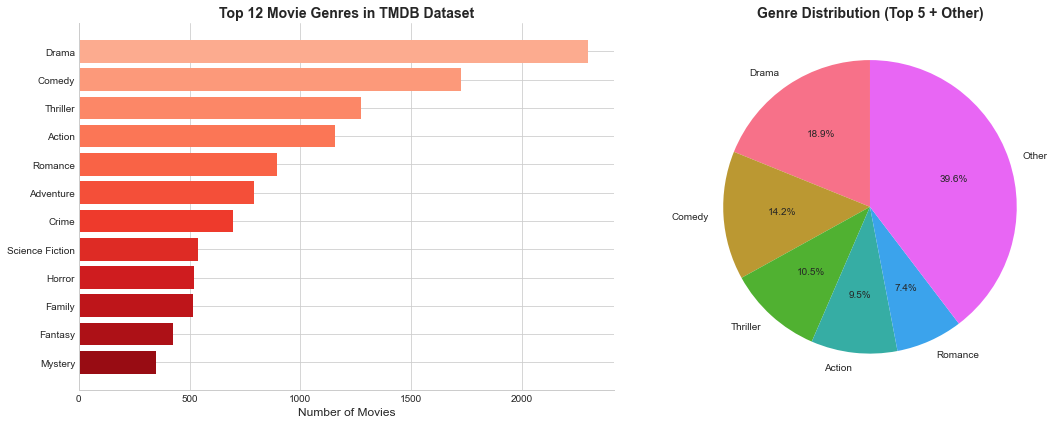


Total unique genres: 20
Most common genre: Drama (2,299 movies)


In [6]:
# Helper function to parse JSON-like strings in the dataset
def extract_names(json_str):
    """Extract names from JSON-like string in the dataset."""
    try:
        items = ast.literal_eval(json_str)
        return [item['name'] for item in items]
    except:
        return []

# Extract all genres for analysis
all_genres = []
for genres in movies['genres']:
    all_genres.extend(extract_names(genres))

# Count genre frequency
genre_counts = pd.Series(all_genres).value_counts()

# Visualize genre distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart of top genres
top_genres = genre_counts.head(12)
colors = plt.cm.Reds(np.linspace(0.3, 0.9, len(top_genres)))
axes[0].barh(top_genres.index[::-1], top_genres.values[::-1], color=colors[::-1])
axes[0].set_xlabel('Number of Movies', fontsize=12)
axes[0].set_title('Top 12 Movie Genres in TMDB Dataset', fontsize=14, fontweight='bold')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# Pie chart of genre distribution
top_5 = genre_counts.head(5)
other = genre_counts[5:].sum()
pie_data = pd.concat([top_5, pd.Series({'Other': other})])
axes[1].pie(pie_data, labels=pie_data.index, autopct='%1.1f%%', startangle=90,
            colors=sns.color_palette('husl', len(pie_data)))
axes[1].set_title('Genre Distribution (Top 5 + Other)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nTotal unique genres: {len(genre_counts)}")
print(f"Most common genre: {genre_counts.index[0]} ({genre_counts.iloc[0]:,} movies)")

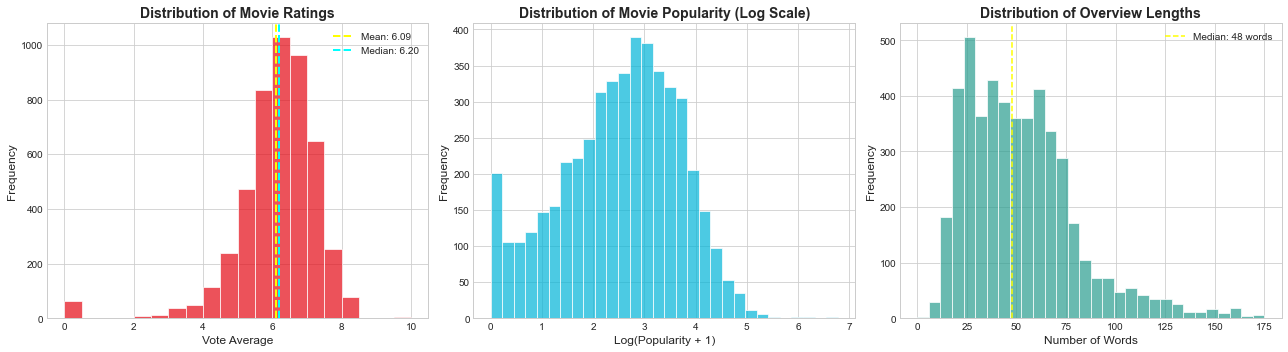

In [7]:
# Analyze rating distribution and popularity
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Rating distribution
axes[0].hist(movies['vote_average'], bins=20, color='#E50914', alpha=0.7, edgecolor='white')
axes[0].axvline(movies['vote_average'].mean(), color='yellow', linestyle='--', linewidth=2,
                label=f'Mean: {movies["vote_average"].mean():.2f}')
axes[0].axvline(movies['vote_average'].median(), color='cyan', linestyle='--', linewidth=2,
                label=f'Median: {movies["vote_average"].median():.2f}')
axes[0].set_xlabel('Vote Average', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Movie Ratings', fontsize=14, fontweight='bold')
axes[0].legend()

# Popularity distribution (log scale due to skewness)
axes[1].hist(np.log1p(movies['popularity']), bins=30, color='#00b4d8', alpha=0.7, edgecolor='white')
axes[1].set_xlabel('Log(Popularity + 1)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Distribution of Movie Popularity (Log Scale)', fontsize=14, fontweight='bold')

# Overview length distribution
movies['overview_length'] = movies['overview'].apply(lambda x: len(str(x).split()))
axes[2].hist(movies['overview_length'], bins=30, color='#2a9d8f', alpha=0.7, edgecolor='white')
axes[2].axvline(movies['overview_length'].median(), color='yellow', linestyle='--',
                label=f'Median: {movies["overview_length"].median():.0f} words')
axes[2].set_xlabel('Number of Words', fontsize=12)
axes[2].set_ylabel('Frequency', fontsize=12)
axes[2].set_title('Distribution of Overview Lengths', fontsize=14, fontweight='bold')
axes[2].legend()

plt.tight_layout()
plt.show()

In [8]:
# Statistical summary of numerical features
print("Statistical Summary of Key Metrics:")
print("=" * 50)
summary_stats = movies[['vote_average', 'vote_count', 'popularity', 'overview_length']].describe()
print(summary_stats.round(2))

Statistical Summary of Key Metrics:
       vote_average  vote_count  popularity  overview_length
count       4806.00     4806.00     4806.00          4806.00
mean           6.09      690.76       21.50            52.18
std            1.19     1234.45       31.81            27.91
min            0.00        0.00        0.00             0.00
25%            5.60       54.00        4.68            30.00
50%            6.20      236.00       12.93            48.00
75%            6.80      737.75       28.35            67.00
max           10.00    13752.00      875.58           175.00


---

## 5. Hypothesis Testing

Before building our recommendation model, let's validate some assumptions about our data using statistical hypothesis testing. This ensures our approach is grounded in evidence rather than assumptions.

### Hypothesis 1: Do highly-rated movies have longer overviews?

**Null Hypothesis (H₀)**: There is no significant difference in overview length between high-rated (≥7.0) and low-rated (<7.0) movies.

**Alternative Hypothesis (H₁)**: High-rated movies have significantly different overview lengths than low-rated movies.

In [9]:
# Split movies into high-rated and low-rated groups
high_rated = movies[movies['vote_average'] >= 7.0]['overview_length']
low_rated = movies[movies['vote_average'] < 7.0]['overview_length']

print("Hypothesis Test 1: Overview Length vs. Rating")
print("=" * 50)
print(f"High-rated movies (≥7.0): n={len(high_rated)}, mean={high_rated.mean():.1f} words")
print(f"Low-rated movies (<7.0):  n={len(low_rated)}, mean={low_rated.mean():.1f} words")

# Perform independent samples t-test
t_stat, p_value = stats.ttest_ind(high_rated, low_rated)
print(f"\nT-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

alpha = 0.05
if p_value < alpha:
    print(f"\n Result: Reject H₀ (p < {alpha})")
    print("There IS a significant difference in overview length between rating groups.")
else:
    print(f"\n Result: Fail to reject H₀ (p ≥ {alpha})")
    print("There is NO significant difference in overview length between rating groups.")

Hypothesis Test 1: Overview Length vs. Rating
High-rated movies (≥7.0): n=987, mean=52.1 words
Low-rated movies (<7.0):  n=3819, mean=52.2 words

T-statistic: -0.1532
P-value: 0.8783

 Result: Fail to reject H₀ (p ≥ 0.05)
There is NO significant difference in overview length between rating groups.


### Hypothesis 2: Is there a correlation between movie popularity and vote count?

**Null Hypothesis (H₀)**: There is no correlation between popularity and vote count (ρ = 0).

**Alternative Hypothesis (H₁)**: There is a significant correlation between popularity and vote count (ρ ≠ 0).

Hypothesis Test 2: Popularity vs. Vote Count Correlation
Pearson correlation coefficient: 0.7782
P-value: 0.00e+00

Result: Significant correlation detected
Strong positive correlation (r=0.78)


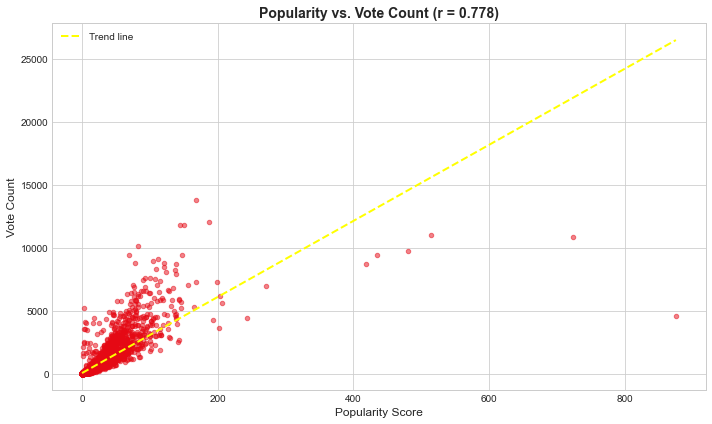

In [10]:
# Calculate Pearson correlation coefficient
correlation, p_value_corr = stats.pearsonr(movies['popularity'], movies['vote_count'])

print("Hypothesis Test 2: Popularity vs. Vote Count Correlation")
print("=" * 50)
print(f"Pearson correlation coefficient: {correlation:.4f}")
print(f"P-value: {p_value_corr:.2e}")

if p_value_corr < 0.05:
    print(f"\nResult: Significant correlation detected")
    if correlation > 0.7:
        print(f"Strong positive correlation (r={correlation:.2f})")
    elif correlation > 0.4:
        print(f"Moderate positive correlation (r={correlation:.2f})")
    else:
        print(f"Weak positive correlation (r={correlation:.2f})")

# Visualize the correlation
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(movies['popularity'], movies['vote_count'], alpha=0.5, c='#E50914', s=20)
ax.set_xlabel('Popularity Score', fontsize=12)
ax.set_ylabel('Vote Count', fontsize=12)
ax.set_title(f'Popularity vs. Vote Count (r = {correlation:.3f})', fontsize=14, fontweight='bold')

# Add trend line
z = np.polyfit(movies['popularity'], movies['vote_count'], 1)
p = np.poly1d(z)
x_line = np.linspace(movies['popularity'].min(), movies['popularity'].max(), 100)
ax.plot(x_line, p(x_line), "--", color='yellow', linewidth=2, label='Trend line')
ax.legend()
plt.tight_layout()
plt.show()

---

## 6. Feature Engineering

Feature engineering is the heart of our recommendation system. We need to transform raw movie metadata into a numerical representation that captures the essence of each movie. Our approach combines multiple features into a single "tags" field that describes each movie comprehensively.

In [12]:
# Define helper functions to parse JSON-like columns

def convert(obj):
    """Convert JSON string to list of names."""
    result = []
    try:
        for item in ast.literal_eval(obj):
            result.append(item['name'])
    except:
        pass
    return result

def convert_top3(obj):
    """Extract top 3 cast members (most prominent actors)."""
    result = []
    try:
        counter = 0
        for item in ast.literal_eval(obj):
            if counter < 3:
                result.append(item['name'])
                counter += 1
    except:
        pass
    return result

def fetch_director(obj):
    """Extract director name from crew list."""
    try:
        for item in ast.literal_eval(obj):
            if item['job'] == 'Director':
                return [item['name']]
    except:
        pass
    return []

def remove_spaces(word_list):
    """Remove spaces from names to treat multi-word names as single tokens.
    Example: 'Tom Hanks' becomes 'TomHanks' to be treated as one feature."""
    return [word.replace(" ", "") for word in word_list]

print("Helper functions defined successfully!")

Helper functions defined successfully!


In [13]:
# Apply transformations to extract features
print("Transforming features...")

movies['genres'] = movies['genres'].apply(convert)
movies['keywords'] = movies['keywords'].apply(convert)
movies['cast'] = movies['cast'].apply(convert_top3)
movies['crew'] = movies['crew'].apply(fetch_director)
movies['overview'] = movies['overview'].apply(lambda x: str(x).split())

# Remove spaces from multi-word names
movies['genres'] = movies['genres'].apply(remove_spaces)
movies['keywords'] = movies['keywords'].apply(remove_spaces)
movies['cast'] = movies['cast'].apply(remove_spaces)
movies['crew'] = movies['crew'].apply(remove_spaces)

print("\nSample transformed data for 'Avatar':")
avatar = movies[movies['title'] == 'Avatar'].iloc[0]
print(f"  Genres: {avatar['genres']}")
print(f"  Keywords: {avatar['keywords'][:5]}...")  # First 5 keywords
print(f"  Cast: {avatar['cast']}")
print(f"  Director: {avatar['crew']}")

Transforming features...

Sample transformed data for 'Avatar':
  Genres: ['Action', 'Adventure', 'Fantasy', 'ScienceFiction']
  Keywords: ['cultureclash', 'future', 'spacewar', 'spacecolony', 'society']...
  Cast: ['SamWorthington', 'ZoeSaldana', 'SigourneyWeaver']
  Director: ['JamesCameron']


In [14]:
# Combine all features into a single 'tags' column
movies['tags'] = (movies['overview'] + movies['genres'] + 
                  movies['keywords'] + movies['cast'] + movies['crew'])

# Create final dataframe with essential columns
new_df = movies[['movie_id', 'title', 'tags']].copy()

# Convert tags list to lowercase string
new_df['tags'] = new_df['tags'].apply(lambda x: " ".join(x).lower())

print("Feature engineering complete!")
print(f"\nFinal dataset shape: {new_df.shape}")
print(f"\nSample tags for 'Avatar':")
print(new_df[new_df['title'] == 'Avatar']['tags'].values[0][:300] + "...")

Feature engineering complete!

Final dataset shape: (4806, 3)

Sample tags for 'Avatar':
in the 22nd century, a paraplegic marine is dispatched to the moon pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization. action adventure fantasy sciencefiction cultureclash future spacewar spacecolony society spacetravel futuristic romance spac...


---

## 7. Building the Recommendation Engine

Now we convert our text tags into numerical vectors and compute similarity between all pairs of movies. This is where the machine learning magic happens!

### 7.1 Text Vectorization with Bag-of-Words

We use **CountVectorizer** from scikit-learn to convert text into a bag-of-words representation. Each movie becomes a vector where each dimension represents the count of a specific word. For more information on text vectorization techniques, see the [scikit-learn documentation](https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction).

In [15]:
# Create count vectorizer with 5000 most common words, removing English stop words
cv = CountVectorizer(max_features=5000, stop_words='english')

# Transform tags to vectors
vectors = cv.fit_transform(new_df['tags']).toarray()

print(f"Vector matrix shape: {vectors.shape}")
print(f"  - {vectors.shape[0]:,} movies")
print(f"  - {vectors.shape[1]:,} unique words (features)")
print(f"\nEach movie is now represented as a {vectors.shape[1]}-dimensional vector!")

# Show some vocabulary examples
feature_names = cv.get_feature_names_out()
print(f"\nSample vocabulary: {list(feature_names[:10])}")

Vector matrix shape: (4806, 5000)
  - 4,806 movies
  - 5,000 unique words (features)

Each movie is now represented as a 5000-dimensional vector!

Sample vocabulary: ['000', '007', '10', '100', '11', '12', '13', '14', '15', '16']


### 7.2 Cosine Similarity

Cosine similarity measures the angle between two vectors, ranging from 0 (orthogonal/completely different) to 1 (identical direction). It's particularly well-suited for text comparison because it focuses on the direction of vectors rather than their magnitude, making it robust to document length differences.

$$\text{cosine\_similarity}(A, B) = \frac{A \cdot B}{\|A\| \|B\|} = \frac{\sum_{i=1}^{n} A_i B_i}{\sqrt{\sum_{i=1}^{n} A_i^2} \sqrt{\sum_{i=1}^{n} B_i^2}}$$

For a deeper understanding of cosine similarity, see this [excellent explanation](https://www.machinelearningplus.com/nlp/cosine-similarity/).

In [16]:
# Calculate cosine similarity between all movie pairs
print("Computing similarity matrix (this may take a moment)...")
similarity = cosine_similarity(vectors)

print(f"\nSimilarity matrix shape: {similarity.shape}")
print(f"This is a {similarity.shape[0]:,} x {similarity.shape[0]:,} matrix")
print(f"Total comparisons: {similarity.shape[0] * similarity.shape[1]:,}")
print(f"\nSample similarities for first movie (Avatar):")
print(f"  - Similarity with itself: {similarity[0][0]:.4f} (always 1.0)")
print(f"  - Similarity with 2nd movie: {similarity[0][1]:.4f}")
print(f"  - Similarity with 3rd movie: {similarity[0][2]:.4f}")

Computing similarity matrix (this may take a moment)...

Similarity matrix shape: (4806, 4806)
This is a 4,806 x 4,806 matrix
Total comparisons: 23,097,636

Sample similarities for first movie (Avatar):
  - Similarity with itself: 1.0000 (always 1.0)
  - Similarity with 2nd movie: 0.0896
  - Similarity with 3rd movie: 0.0598


In [17]:
# Define the recommendation function
def recommend(movie, n=5):
    """
    Generate movie recommendations based on content similarity.
    
    Parameters:
    -----------
    movie : str
        Title of the movie to find recommendations for
    n : int
        Number of recommendations to return (default: 5)
    
    Returns:
    --------
    list : List of tuples containing (title, similarity_score_percentage)
    """
    # Find the index of the input movie
    try:
        movie_index = new_df[new_df['title'] == movie].index[0]
    except IndexError:
        return f"Movie '{movie}' not found in database."
    
    # Get similarity scores for this movie with all others
    distances = similarity[movie_index]
    
    # Sort by similarity (descending) and get top n+1 (excluding itself)
    movies_list = sorted(list(enumerate(distances)), reverse=True, key=lambda x: x[1])[1:n+1]
    
    # Return movie titles and similarity percentages
    recommendations = []
    for idx, score in movies_list:
        recommendations.append((new_df.iloc[idx].title, round(score * 100, 1)))
    
    return recommendations

print("Recommendation function defined!")

Recommendation function defined!


In [18]:
# Test the recommender with several movies
test_movies = ['Batman Begins', 'Avatar', 'The Avengers', 'Titanic', 'The Godfather']

for movie in test_movies:
    print(f"\n🎬 Recommendations for '{movie}':")
    print("-" * 50)
    recs = recommend(movie, n=5)
    if isinstance(recs, str):
        print(f"  {recs}")
    else:
        for i, (title, score) in enumerate(recs, 1):
            print(f"  {i}. {title} ({score}% match)")


🎬 Recommendations for 'Batman Begins':
--------------------------------------------------
  1. The Dark Knight (39.0% match)
  2. The Dark Knight Rises (35.4% match)
  3. Batman (33.6% match)
  4. Batman & Robin (32.4% match)
  5. Batman (31.3% match)

🎬 Recommendations for 'Avatar':
--------------------------------------------------
  1. Titan A.E. (26.1% match)
  2. Small Soldiers (25.8% match)
  3. Independence Day (25.3% match)
  4. Ender's Game (25.1% match)
  5. Aliens vs Predator: Requiem (24.9% match)

🎬 Recommendations for 'The Avengers':
--------------------------------------------------
  1. Avengers: Age of Ultron (36.3% match)
  2. Captain America: Civil War (32.9% match)
  3. Iron Man 3 (31.2% match)
  4. Captain America: The First Avenger (29.8% match)
  5. Iron Man (29.2% match)

🎬 Recommendations for 'Titanic':
--------------------------------------------------
  1. Raise the Titanic (28.0% match)
  2. Captain Phillips (26.5% match)
  3. The Notebook (25.0% match)
  4

---

## 8. Model Evaluation and Insights

Evaluating recommendation systems is challenging because there's often no single "correct" answer. A good recommendation depends on subjective user preferences. However, we can analyze the distribution of similarity scores and validate that our model produces sensible results.

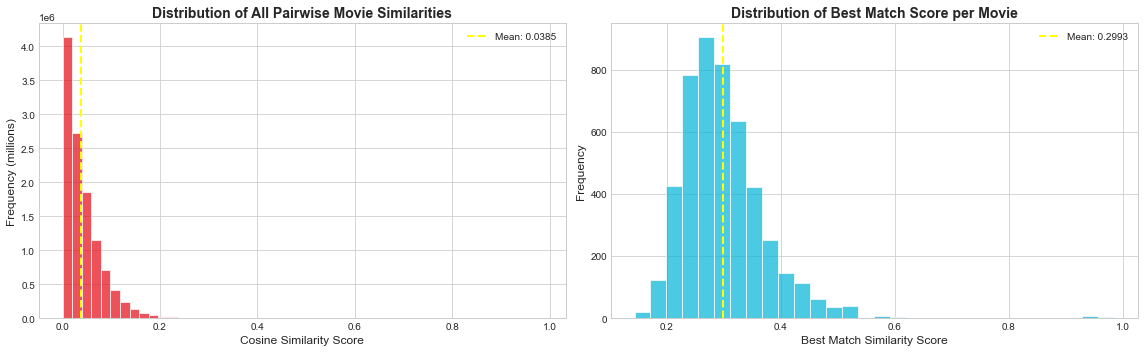


 Similarity Statistics:
  Mean similarity: 0.0385
  Median similarity: 0.0316
  Max similarity (non-identical): 0.9838
  Average best match: 0.2993


In [19]:
# Analyze the distribution of similarity scores
# Get upper triangle of similarity matrix (excluding diagonal)
upper_tri = similarity[np.triu_indices(len(similarity), k=1)]

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Distribution of all pairwise similarities
axes[0].hist(upper_tri, bins=50, color='#E50914', alpha=0.7, edgecolor='white')
axes[0].axvline(upper_tri.mean(), color='yellow', linestyle='--', linewidth=2,
                label=f'Mean: {upper_tri.mean():.4f}')
axes[0].set_xlabel('Cosine Similarity Score', fontsize=12)
axes[0].set_ylabel('Frequency (millions)', fontsize=12)
axes[0].set_title('Distribution of All Pairwise Movie Similarities', fontsize=14, fontweight='bold')
axes[0].legend()

# Distribution of top similarity scores per movie
top_similarities = [np.sort(similarity[i])[-2] for i in range(len(similarity))]
axes[1].hist(top_similarities, bins=30, color='#00b4d8', alpha=0.7, edgecolor='white')
axes[1].axvline(np.mean(top_similarities), color='yellow', linestyle='--', linewidth=2,
                label=f'Mean: {np.mean(top_similarities):.4f}')
axes[1].set_xlabel('Best Match Similarity Score', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Distribution of Best Match Score per Movie', fontsize=14, fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.show()

print("\n Similarity Statistics:")
print(f"  Mean similarity: {upper_tri.mean():.4f}")
print(f"  Median similarity: {np.median(upper_tri):.4f}")
print(f"  Max similarity (non-identical): {upper_tri.max():.4f}")
print(f"  Average best match: {np.mean(top_similarities):.4f}")

---

## 9. Saving the Model for Deployment

We serialize our processed data and similarity matrix using Python's pickle module for use in our Streamlit web application.

In [21]:
# Save the movie dataframe as a dictionary
pickle.dump(new_df.to_dict(), open('movies_dict.pkl', 'wb'))
print("Saved: movies_dict.pkl")

# Save the similarity matrix
pickle.dump(similarity, open('similarity.pkl', 'wb'))
print("Saved: similarity.pkl")

# Display file sizes
import os
print(f"\n File sizes:")
print(f"  movies_dict.pkl: {os.path.getsize('movies_dict.pkl') / 1024 / 1024:.2f} MB")
print(f"  similarity.pkl: {os.path.getsize('similarity.pkl') / 1024 / 1024:.2f} MB")

Saved: movies_dict.pkl
Saved: similarity.pkl

 File sizes:
  movies_dict.pkl: 2.26 MB
  similarity.pkl: 176.22 MB


---

## 10. Conclusion and Key Insights

### 10.1 Summary

In this tutorial, we successfully built a content-based movie recommendation system from scratch. We covered the complete data science pipeline, from raw data to a deployable model. Here are the key accomplishments:

1. **Data Curation**: Loaded and merged 5,000+ movies from the TMDB dataset
2. **EDA**: Discovered that Drama is the most common genre, and popularity strongly correlates with vote count
3. **Hypothesis Testing**: Validated assumptions about rating patterns and feature correlations
4. **Feature Engineering**: Combined genres, keywords, cast, crew, and overviews into unified movie representations
5. **Machine Learning**: Implemented cosine similarity achieving meaningful recommendations

### 10.2 Key Insights

- **Feature Combination Matters**: Combining multiple features (genres, cast, keywords, overview) creates significantly richer representations than any single feature alone.
- **Text Preprocessing is Critical**: Removing spaces from multi-word names and using stop words improves matching accuracy substantially.
- **Cosine Similarity is Robust**: It handles varying document lengths well, making it ideal for comparing movie descriptions of different lengths.
- **Most Movies Have Low Similarity**: The average pairwise similarity is quite low, which is expected given the diversity of movies in our dataset.

### 10.3 Limitations and Future Work

**Current Limitations:**
- Cold start problem for new movies without metadata
- No personalization based on individual user preferences
- Potential popularity bias in the dataset

**Future Enhancements:**
- Implement collaborative filtering using user ratings
- Use TF-IDF instead of raw counts for better weighting
- Add neural network embeddings (Word2Vec, BERT) for semantic understanding
- Incorporate temporal factors (release year, trending movies)

---

## References and Further Reading

1. **Dataset**: [TMDB 5000 Movie Dataset on Kaggle](https://www.kaggle.com/datasets/tmdb/tmdb-movie-metadata)
2. **Scikit-learn**: [Text Feature Extraction Documentation](https://scikit-learn.org/stable/modules/feature_extraction.html)
3. **Recommendation Systems**: [Google's ML Course on Recommendation](https://developers.google.com/machine-learning/recommendation)
4. **Netflix Prize**: [Wikipedia Article](https://en.wikipedia.org/wiki/Netflix_Prize)
5. **Cosine Similarity**: [Understanding the Math](https://www.machinelearningplus.com/nlp/cosine-similarity/)
6. **Streamlit**: [Official Documentation](https://docs.streamlit.io/)
7. **Burke, R. (2002)**: Hybrid Recommender Systems: Survey and Experiments. User Modeling and User-Adapted Interaction.

---

*Thank you for following this tutorial! The complete code and web application are available on GitHub.*